In [8]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import json
from datetime import datetime, timedelta

# Projektionsdefinitionen
lv95 = pyproj.Proj(init='epsg:2056')
wgs84 = pyproj.Proj(init='epsg:4326')

# Funktion zur Konvertierung von LV95 nach WGS84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Funktion zum Laden des Straßennetzwerks
def load_street_network(north, south, east, west):
    return ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

# Funktion zum Speichern des Straßennetzwerks als GeoPackage
def save_street_network(G, filepath):
    ox.io.save_graph_geopackage(G, filepath)

# Funktion zum Hinzufügen der Rückfahrt-Haltestellen
def add_return_trip(bus_stops):
    return_trip_stops = bus_stops.iloc[:-1].iloc[::-1]
    return pd.concat([bus_stops, return_trip_stops], ignore_index=True)

# Funktion zur Bestimmung des nächsten Netzwerkknotens zu einem Punkt
def get_nearest_node(G, point):
    return ox.distance.nearest_nodes(G, point.x, point.y)

# Funktion zum Berechnen des kürzesten Pfads zwischen den Haltestellen
def compute_shortest_paths(G, points_gdf, start_time):
    routes = []
    route_lengths = []
    ankunftszeiten = []

    # Startzeit als datetime-Objekt parsen
    aktuelle_zeit = start_time
    ankunftszeiten.append(aktuelle_zeit)
    v = 12  # Geschwindigkeit in m/s

    for idx, row in points_gdf.iterrows():
        orig = get_nearest_node(G, row['geometry'])
        next_idx = (idx + 1) % len(points_gdf)
        next_row = points_gdf.iloc[next_idx]
        dest = get_nearest_node(G, next_row['geometry'])

        # Berechne die Fahrzeit für die aktuelle Route
        route = ox.shortest_path(G, orig, dest, weight="length")
        routes.append(route)
        route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
        route_lengths.append(route_length)

        # Berechne die Reisezeit in Sekunden
        route_travel_time = route_length / v
        aktuelle_zeit += timedelta(seconds=route_travel_time)
        ankunftszeiten.append(aktuelle_zeit)

        # Füge eine 10-minütige Pause in der Hälfte der Stopps ein
        if (idx + 1) % (len(points_gdf) // 2) == 0:
            aktuelle_zeit += timedelta(minutes=5)

    # Füge die Ankunftszeiten als neue Spalte zur GeoDataFrame hinzu
    points_gdf['ankunftszeit'] = ankunftszeiten[:-1]  # Letzte Zeit ist für den nächsten Startpunkt

    return routes, route_lengths, points_gdf


def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]
    bus_stop_times = list(bus_stops_gdf['ankunftszeit'])

    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        start_gemeinde = demand_feature['properties']['gemeinde']
        passenger_destination = Point(dest_feature['geometry']['coordinates'])
        end_gemeinde = dest_feature['properties']['gemeinde']
        passenger_time = datetime.strptime(demand_feature['properties']['timestamp'], '%Y-%m-%dT%H:%M:%S')

        origin_in_buffer = False
        destination_in_buffer = False
        start = None
        end = None
        start_time = None
        end_time = None

        for coord, stop_time in zip(bus_stop_coords, bus_stop_times):
            bus_stop_point = Point(coord)
            start_buffer = stop_time - timedelta(minutes=10)
            end_buffer = stop_time + timedelta(minutes=10)

            if bus_stop_point.buffer(500).contains(passenger_origin) and start_buffer <= passenger_time <= end_buffer:
                origin_in_buffer = True
                start = bus_stop_point
                start_time = stop_time

            if bus_stop_point.buffer(500).contains(passenger_destination) and start_buffer <= passenger_time <= end_buffer:
                destination_in_buffer = True
                end = bus_stop_point
                end_time = stop_time

            # Überprüfen, ob die Start- und Endpunkte unterschiedliche Bushaltestellen sind und die Startzeit vor der Endzeit liegt
            if origin_in_buffer and destination_in_buffer and start != end and start_time < end_time:
                passengers.append({
                    'origin': passenger_origin,
                    'start gemeinde': start_gemeinde,
                    'destination': passenger_destination,
                    'end gemeinde': end_gemeinde,
                    'start': start,
                    'end': end,
                    'stoptime start': start_time,
                    'stoptime end': end_time,
                    'timestamp': passenger_time
                })
                break

    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    return passengers_gdf

def compute_travel_time(passengers_gdf):
    travel_times = []
    for idx, row in passengers_gdf.iterrows():
        start = row['stoptime start']
        end = row['stoptime end']
        travel_time = end - start
        travel_times.append(travel_time)

    passengers_gdf['travel_time'] = travel_times
    return passengers_gdf

def compute_travel_time_bus(busstops_with_time):
    # Konvertieren der 'timestamp'-Spalte in datetime-Objekte
    busstops_with_time['ankunftszeit'] = pd.to_datetime(busstops_with_time['ankunftszeit'])

    # Zugriff auf den ersten und letzten Eintrag der 'timestamp'-Spalte
    first_timestamp = busstops_with_time['ankunftszeit'].iloc[0]
    last_timestamp = busstops_with_time['ankunftszeit'].iloc[-1]

    # Berechnung der Reisezeit
    travel_time = last_timestamp - first_timestamp

    return travel_time


def plot_passengers(passengers_gdf, bus_stops_gdf, demand_geojson, destination_geojson, gemeindegrenzen):
    fig, ax = plt.subplots(figsize=(10, 8))

    bus_stops_gdf.plot(ax=ax, color='grey', markersize=30, label='Bus Stops')

    for feature in demand_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'go', markersize=6)

    for feature in destination_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'bo', markersize=6)

    origin_gdf = passengers_gdf[['origin', 'timestamp']].copy()
    destination_gdf = gpd.GeoDataFrame()
    destination_gdf['destination'] = None
    destination_gdf['geometry'] = passengers_gdf['destination'].apply(Point)
    destination_gdf = gpd.GeoDataFrame(destination_gdf)
    destination_gdf.set_geometry('geometry', inplace=True)

    origin_gdf.plot(ax=ax, color='orange', markersize=20, label='Origin Points', zorder=2)
    destination_gdf.plot(ax=ax, color='yellow', markersize=20, label='Destination Points', zorder=2)

    gemeindegrenzen.plot(ax=ax, color='black', alpha=0.5, label='Shapefile')

    ax.set_title('Bus Stops, Demand and Destination Points, and Passengers')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    demand_legend = plt.Line2D([], [], color='green', marker='o', markersize=8, linestyle='None', label='Demand Points')
    destination_legend = plt.Line2D([], [], color='blue', marker='o', markersize=8, linestyle='None', label='Destination Points')
    passengers_demand_legend = plt.Line2D([], [], color='orange', marker='o', markersize=8, linestyle='None', label='Passengers origin')
    passengers_destination_legend = plt.Line2D([], [], color='yellow', marker='o', markersize=8, linestyle='None', label='Passengers destination')

    ax.legend(handles=[demand_legend, destination_legend, passengers_demand_legend, passengers_destination_legend], loc='upper left')

    plt.show()

def count_passengers(passengers_gdf):
    num_passengers = passengers_gdf.shape[0]
    return num_passengers
    print("Anzahl der Passagiere im Bus:", num_passengers)

# Funktion zum Plotten der Routen auf dem Straßennetzwerk
def plot_routes(G, routes):
    fig, ax = ox.plot_graph_routes(G, routes, node_size=0)
    plt.show()


c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_DOCS = 'src/main/resources/Dokumente/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

# Lade und die Gemeindegrenzen
shp_file = ROOT_FILES + 'src/main/resources/QGIS/Gemeindegrenzen/Grenzen_komp.shp'
gemeindegrenzen = gpd.read_file(shp_file)

# Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Definieren des Bereichs für das Straßennetzwerk
north, south, east, west = 47.3667, 47.2586, 8.754, 8.6103

# Laden des Straßennetzwerks
G = load_street_network(north, south, east, west)

# Füge Geschwindigkeit zu den Kanten des Graphen hinzu (benötigt für die travel_time-Berechnung)
#G = ox.add_edge_speeds(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
#G = ox.add_edge_travel_times(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
#G = ox.add_edge_travel_times(ox.add_edge_speeds(G))

# Laden der Bushaltestellen
bus_stops = gpd.read_file(ROOT_FILES + ROOT_Busstations + "Bushalte.shp")

# Hinzufügen der Rückfahrt-Haltestellen
bus_stops_with_return = add_return_trip(bus_stops)

#Bestimme Abfahrtszeit der Busse
start_timestamp = pd.Timestamp('2018-04-20 09:05:00')

# Konvertierung der Bushaltestellenprojektion von LV95 nach WGS84
bus_stops_with_return_wgs84 = bus_stops_with_return.copy()
bus_stops_with_return_wgs84['geometry'] = bus_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)

# Berechnung der kürzesten Routen zwischen den Haltestellen
routes, route_lengths, busstops_with_time = compute_shortest_paths(G, bus_stops_with_return_wgs84, start_timestamp)

#print(busstops_with_time)

bus_stops_with_return['ankunftszeit'] = busstops_with_time['ankunftszeit']
#print(bus_stops_with_return)

# Plotten der Routen auf dem Straßennetzwerk
#plot_routes(G, routes)


file_path_demand = ROOT_FILES + ROOT_DOCS + "Nachfrage_bahnhof.geojson"
file_path_destination = ROOT_FILES + ROOT_DOCS + "Ziele_bahnhof.geojson"
demand_geojson = load_geojson(file_path_demand)
destination_geojson = load_geojson(file_path_destination)

# Bestimme die Passagiere im Bus
passengers_gdf = passengers_on_bus(bus_stops_with_return, demand_geojson, destination_geojson)
#print(passengers_gdf)

# Berechne die Reisezeit der Passagiere
passengers_gdf = compute_travel_time(passengers_gdf)
print(passengers_gdf)

# Berechne die Gesamtreisezeit
total_travel_time = compute_travel_time_bus(busstops_with_time)
print("Die gesamte Reisezeit beträgt:", total_travel_time)
#plot_passengers(passengers_gdf, bus_stops_with_return, demand_geojson, destination_geojson, gemeindegrenzen)

# Berechnung der Gesamtlänge der Route
total_route_length = sum(route_lengths) / 1000
print("Gesamtlänge der Route:", total_route_length, "Kilometer")
# Gib die Anzahl Passagiere zurück
num_passengers = count_passengers(passengers_gdf)
print("Anzahl der Passagiere im Bus:", num_passengers)

C:\Users\Linus\AppData\Local\Temp\ipykernel_13808\987481611.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_13808\987481611.py:58: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_13808\987481611.py:58: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_13808\987481611.py:58: UserWarning: The `get_route_edge_attributes` func

                            origin start gemeinde  \
0  POINT (2694601.091 1239702.123)            Egg   
1  POINT (2694601.091 1239702.123)            Egg   
2  POINT (2694601.091 1239702.123)            Egg   
3  POINT (2694601.091 1239702.123)            Egg   
4  POINT (2696587.614 1243723.222)          Uster   
5  POINT (2696622.343 1245221.347)          Uster   
6  POINT (2691108.391 1236294.995)         Meilen   
7  POINT (2691968.081 1236234.731)         Meilen   
8  POINT (2692606.591 1235826.747)         Meilen   

                                     destination end gemeinde  \
0  POINT (2696195.7886055475 1243215.3472948675)          Egg   
1   POINT (2691216.542487097 1236096.9463869543)          Egg   
2   POINT (2691216.542487097 1236096.9463869543)          Egg   
3    POINT (2696622.343406618 1245221.347068825)          Egg   
4  POINT (2694567.9993949244 1239611.3107597493)          Egg   
5  POINT (2694560.9397718534 1239509.1941757742)        Uster   
6    POINT (26

In [3]:
print(passengers_gdf)

                             origin start gemeinde  \
0   POINT (2694389.459 1239450.522)            Egg   
1   POINT (2694601.091 1239702.123)            Egg   
2   POINT (2694601.091 1239702.123)            Egg   
3   POINT (2694601.091 1239702.123)            Egg   
4   POINT (2694601.091 1239702.123)            Egg   
5   POINT (2694601.091 1239702.123)            Egg   
6   POINT (2694601.091 1239702.123)            Egg   
7   POINT (2694601.091 1239702.123)            Egg   
8   POINT (2696587.614 1243723.222)          Uster   
9   POINT (2696622.343 1245221.347)          Uster   
10  POINT (2696622.343 1245221.347)          Uster   
11  POINT (2691108.391 1236294.995)         Meilen   
12  POINT (2691968.081 1236234.731)         Meilen   
13  POINT (2692606.591 1235826.747)         Meilen   
14  POINT (2691216.542 1236096.946)         Meilen   

                                      destination end gemeinde  \
0    POINT (2696358.578626856 1243509.5444993412)        Uster   
1  

In [4]:
#print(busstops_with_time)
#print(bus_stops_with_return)
#print(bus_stops_with_return_wgs84)

In [5]:
def add_zones_to_gdf(passengers_gdf):
    # Iteriere über die Zeilen des DataFrames
    for index, row in passengers_gdf.iterrows():
        if row['start gemeinde'] == row['end gemeinde']:
            passengers_gdf.at[index, 'zone'] = 1
        elif (row['start gemeinde'] == 'Meilen' and row['end gemeinde'] == 'Uster') or \
             (row['start gemeinde'] == 'Uster' and row['end gemeinde'] == 'Meilen'):
            passengers_gdf.at[index, 'zone'] = 3
        elif row['start gemeinde'] != row['end gemeinde']:
            passengers_gdf.at[index, 'zone'] = 2
    return passengers_gdf

# Beispielhafte Verwendung der Funktion
passengers_gdf = add_zones_to_gdf(passengers_gdf)
print(passengers_gdf)


                             origin start gemeinde  \
0   POINT (2694389.459 1239450.522)            Egg   
1   POINT (2694601.091 1239702.123)            Egg   
2   POINT (2694601.091 1239702.123)            Egg   
3   POINT (2694601.091 1239702.123)            Egg   
4   POINT (2694601.091 1239702.123)            Egg   
5   POINT (2694601.091 1239702.123)            Egg   
6   POINT (2694601.091 1239702.123)            Egg   
7   POINT (2694601.091 1239702.123)            Egg   
8   POINT (2696587.614 1243723.222)          Uster   
9   POINT (2696622.343 1245221.347)          Uster   
10  POINT (2696622.343 1245221.347)          Uster   
11  POINT (2691108.391 1236294.995)         Meilen   
12  POINT (2691968.081 1236234.731)         Meilen   
13  POINT (2692606.591 1235826.747)         Meilen   
14  POINT (2691216.542 1236096.946)         Meilen   

                                      destination end gemeinde  \
0    POINT (2696358.578626856 1243509.5444993412)        Uster   
1  

In [6]:
def calculate_income(passengers_gdf):
    # Berechne den Gesamteinnahmen
    income = 0
    for index, row in passengers_gdf.iterrows():
        if row['zone'] == 1:
            passengers_gdf.at[index, 'income'] = 2.80 # CHF
        elif row['zone'] == 2:
            passengers_gdf.at[index, 'income'] = 4.60 # CHF
        elif row['zone'] == 3:
            passengers_gdf.at[index, 'income'] = 7.00 # CHF
    return passengers_gdf

# Beispielhafte Verwendung der Funktion
passengers_gdf = calculate_income(passengers_gdf)
print(passengers_gdf)

                             origin start gemeinde  \
0   POINT (2694389.459 1239450.522)            Egg   
1   POINT (2694601.091 1239702.123)            Egg   
2   POINT (2694601.091 1239702.123)            Egg   
3   POINT (2694601.091 1239702.123)            Egg   
4   POINT (2694601.091 1239702.123)            Egg   
5   POINT (2694601.091 1239702.123)            Egg   
6   POINT (2694601.091 1239702.123)            Egg   
7   POINT (2694601.091 1239702.123)            Egg   
8   POINT (2696587.614 1243723.222)          Uster   
9   POINT (2696622.343 1245221.347)          Uster   
10  POINT (2696622.343 1245221.347)          Uster   
11  POINT (2691108.391 1236294.995)         Meilen   
12  POINT (2691968.081 1236234.731)         Meilen   
13  POINT (2692606.591 1235826.747)         Meilen   
14  POINT (2691216.542 1236096.946)         Meilen   

                                      destination end gemeinde  \
0    POINT (2696358.578626856 1243509.5444993412)        Uster   
1  

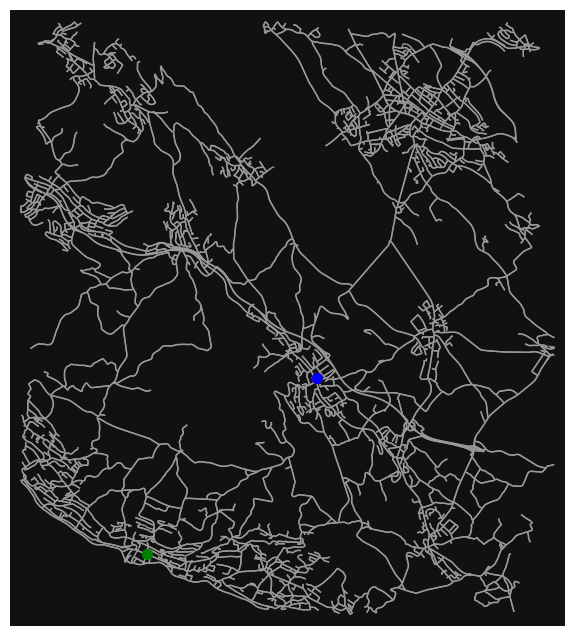

Route von 335539182 nach 218307467 ist 445.26800000000003 lang
Route von 335539182 nach 218307467 dauert 0.1 Minuten


C:\Users\Linus\AppData\Local\Temp\ipykernel_13808\1396447060.py:28: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))


In [7]:
def plot_nodes_on_graph(G, nodes_list, colors):
    """
    Plots the specified nodes on the graph with different colors.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - nodes_list (list): List of manual node IDs.
        - colors (list): List of colors corresponding to each node.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere die manuellen Nodes mit unterschiedlichen Farben
    for node_id, color in zip(nodes_list, colors):
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        ax.scatter(*node_position, color=color, s=50, zorder=5)
    
    # Anzeigen des Plots
    plt.show()

# Beispielaufruf der Funktion mit einer Liste von manuellen Nodes und Farben
manual_nodes_list = [393962506, 66861087, 393962506]
node_colors = ['red', 'green', 'blue']  # Beispielhafte Farben für die Punkte
plot_nodes_on_graph(G, manual_nodes_list, node_colors)

orig, dest = 335539182, 218307467
route = ox.shortest_path(G, orig, dest, weight="length")
route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
route_travel_time = nx.shortest_path_length(G, orig, dest, weight='travel_time') / 60
route_travel_time = nx.shortest_path_length(G, orig, dest, weight='travel_time') / 60
        
print(f"Route von {orig} nach {dest} ist {route_length} lang")
print(f"Route von {orig} nach {dest} dauert {route_travel_time} Minuten")